# Pastas TimeSeries Objects
R.A. Collenteur, 04-11-2017, Artesia Water

In this Jupyter Notebook, the concept of the Pastas TimeSeries class is explained in full detail. The Pastas TimeSeries class is basically an enhanced Pandas Series object, indeed enheriting from that class as well, with some features specific for its use in Pastas. Documentation on the Pandas Series can be found here: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html

The central thought for the design of this class was that all manipulations made on the user-provided dependent and independent time series should be handled within this class. Moreover, while manipulating the TimeSeries when working with your Pastas model, the original data should be maintained such that only the definition of the TimeSeries and the original series can be stored. The definition of the class can be found on Github (https://github.com/pastas/pastas/blob/dev/pastas/timeseries.py)



In [1]:
import pastas as ps
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

##  1. Importing groundwater time series
Let's first import some time series so we have some data to play around with. We use Pandas read_csv method and obtain a Pandas Series object, pandas data structure to efficiently deal with 1D Time Series data. By default, Pandas adds a wealth of functionalities to a Series object, such as descriptive statistics (series.describe()) and plotting funtionality.

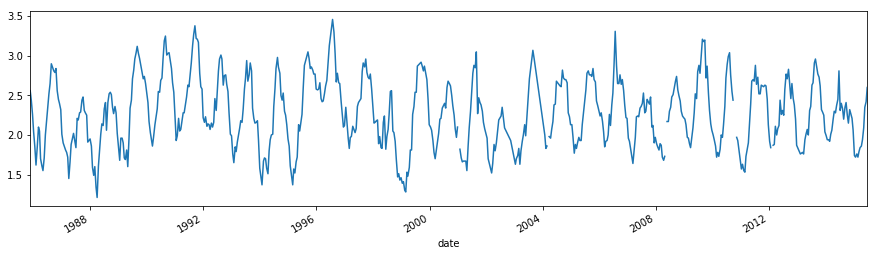

In [2]:
gwdata = pd.read_csv('../data/B58C0698001_0.csv', skiprows=11,
                     parse_dates=['PEIL DATUM TIJD'],
                     index_col='PEIL DATUM TIJD',
                     skipinitialspace=True)
gwdata.rename(columns={'STAND (MV)': 'h'}, inplace=True)
gwdata.index.names = ['date']
gwdata = gwdata.h * 0.01
gwdata.plot(figsize=(15,4))

## 2. Creating a Pastas TimeSeries object
The user will provide time series data when creating a model instance, or one of the tseries elements found in tseries.py. Pastas expects Pandas Series as a standard format in which time series are provided, but will internally transform these to Pastas TimeSeries objects to add the necessary funtionality. It is therefore also possible to provide a TimeSeries object directly instead of a Pandas Series object.

We will now create a TimeSeries object for the groundwater level (gwdata). When creating a TimeSeries object the time series that are provided are validated, such that Pastas can use the provided time series for simulation without errors. The time series are checked for:

1. Being actual Pandas Series object;
2. Making sure the indices are all TimeStamps;
3. Making sure the indices are ordered in time;
4. Dropping any nan-values before and after the first and final valid value;
5. Frequency of the Series is inferred, or otherwise the user-provided value for "freq" is applied;
6. Nan-values within the series are handled, depending on the value for the "fill_nan" argument;
7. Duplicate indices are dropped from the series.

If all of the above is OK, a TimeSeries object is returned. When valid time series are provided all of the above checks are no problem and no settings are required. However, all to often this is not the case and at least "fill_nan" and "freq" are required. The first argument tells the TimeSeries object how to handle nan-values, and the freq argument provides the frequency of the original time series (default freq=D, fill_nan="interpolate").

User-provided frequency is applied when validating the Time Series Groundwater Level. Make sure the provided frequency is close to the real frequency of the original series.


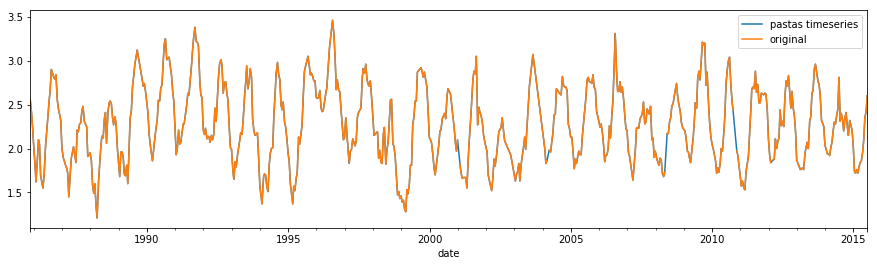

In [3]:
oseries = ps.TimeSeries(gwdata, name="Groundwater Level")

# Plot the new time series and the original
oseries.plot(figsize=(15,4), label="pastas timeseries")
gwdata.plot(label="original")
plt.legend()

## 3. Configuring a TimeSeries object
So let's see how we can configure a TimeSeries object. In the case of the observed groundwater levels (oseries) as in the example above, interpolating between observations might not be the preffered method to deal with gaps in your data. In fact, the do not have to be constant for simulation, one of the benefits of the method of impulse response functions. The nan-values can simply be dropped. To configure a TimeSeries object the user has three options:

1. Use a predefined configuration by using the kind="type" argument
2. providing a dictonary with the options
3. Providing the arguments as keyword arguments

For example, when creating a TimeSeries object for the groundwater levels consider the following examples for setting the fill_nan option:

In [4]:
# Options 1
oseries = ps.TimeSeries(gwdata, name="Groundwater Level", kind="oseries")
print(oseries.settings)

{'freq': 'D', 'sample_up': None, 'sample_down': None, 'fill_nan': 'drop', 'fill_before': None, 'fill_after': None, 'tmin': Timestamp('1985-11-14 00:00:00'), 'tmax': Timestamp('2015-06-28 00:00:00'), 'norm': None}


In [5]:
# Option 2
oseries = ps.TimeSeries(gwdata, name="Groundwater Level", fill_nan="drop")
print(oseries.settings)

{'freq': 'D', 'sample_up': None, 'sample_down': None, 'fill_nan': 'drop', 'fill_before': None, 'fill_after': None, 'tmin': Timestamp('1985-11-14 00:00:00'), 'tmax': Timestamp('2015-06-28 00:00:00'), 'norm': None}


In [6]:
# Options 3
oseries = ps.TimeSeries(gwdata, name="Groundwater Level", settings=dict(fill_nan="drop"))
print(oseries.settings)

{'freq': 'D', 'sample_up': None, 'sample_down': None, 'fill_nan': 'drop', 'fill_before': None, 'fill_after': None, 'tmin': Timestamp('1985-11-14 00:00:00'), 'tmax': Timestamp('2015-06-28 00:00:00'), 'norm': None}


### Wait, what?
All of the above methods yield the same result. It is up to the user which one is preferred. A question that may arise with options 1, is what the possible values for `kind` are and what configuration is then used. You can ask the TimeSeries class this question:

In [7]:
pd.DataFrame(ps.TimeSeries._kind_settings).T

,fill_after,fill_before,fill_nan,freq,sample_down,sample_up
evap,mean,mean,interpolate,D,sum,interpolate
oseries,None,None,drop,D,None,None
prec,mean,mean,0,D,sum,mean
waterlevel,mean,mean,interpolate,D,interpolate,mean
well,0,0,0,D,sum,bfill


## 4. Let's explore the possibilities
As said, Pastas TimeSeries are capable of handling time series in a way that is convenient for Pastas. 

- Changing the frequency of the time series (sample_up, sameple_down)
- Extending the time series (fill_before and fill_after)
- Normalizing the time series (norm *not fully supported yet)

We will now import some precipitation series measured at a daily frequency and show how the above methods work

In [8]:
# Import observed precipitation series
precip = pd.read_csv('../data/Heibloem_rain_data.dat', skiprows=4, 
                     delim_whitespace=True, parse_dates=['date'], 
                     index_col='date')
precip = precip.precip["2012"]
precip /= 1000.0  # Meters
prec = ps.TimeSeries(precip, name="Precpipitation", kind="prec")

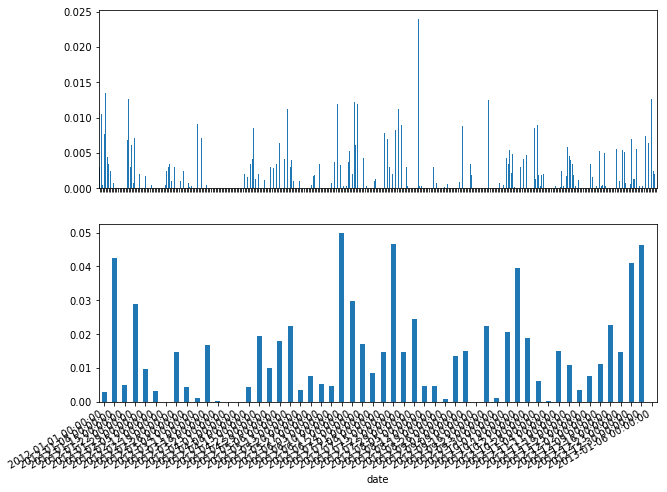

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))
prec.update_series(freq="D")
prec.plot.bar(ax=ax[0])
prec.update_series(freq="W")
prec.plot.bar(ax=ax[1])

import matplotlib.dates as mdates
ax[1].fmt_xdata = mdates.DateFormatter('%m')
fig.autofmt_xdate()

### Wait, what?
For those of you wondering what just happened, some more words. We just changed the frequency of the TimeSeries without a problem. When reducing the frequency, the values were summed into the new bins. Conveniently, ALL pandas methods are still available and functional, such as the great plotting functionalities of Pandas.

All this happened `inplace`, meaning the same object just took another shape based on the new settings. Moreover, it performed those new settings (`freq="W"` weekly values) on the original series. This means that going back and forth between frequencies does not lead to any information loss. 

Why is this so important? Because when solving or simulating a model, the Model will ask every member of the TimeSeries family to prepare itself with the necessary settings (e.g. new freq) and perform that operation only once. When asked for a time series, the TimeSeries object will "be" in that new shape.

### Some more action

Let's say, we want to simulate the groundwater series for a period where no data is available for the time series, but we need some kind of value for the warmup period to prevent things from getting messy. The TimeSeries object can easily extend itself, as the following example shows. 

{'fill_after': 'mean',
 'fill_before': 'mean',
 'fill_nan': 0.0,
 'freq': 'W',
 'norm': None,
 'sample_down': 'sum',
 'sample_up': 'mean',
 'tmax': Timestamp('2012-12-31 00:00:00'),
 'tmin': '2011'}

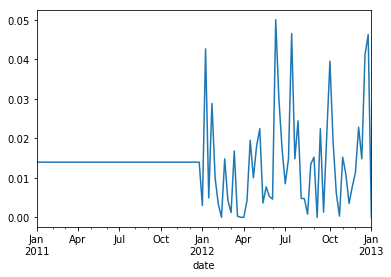

In [10]:
prec.update_series(tmin="2011")
prec.plot()
prec.settings

## 5. Exporting the TimeSeries
When done, we might want to store the TimeSeries object for later use. A `dump` method is built-in to export the original time series to a json format, along with its current settings and name. This way the original data is maintained and can easily be recreated from a json file. 

In [11]:
data = prec.dump()
print(data.keys())

dict_keys(['series', 'name', 'kind', 'settings', 'metadata'])


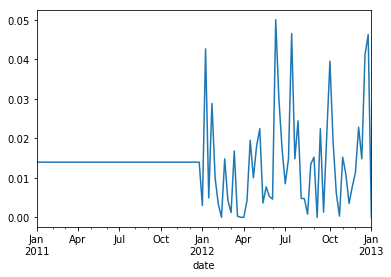

In [12]:
# Tadaa, we have our extended time series in weekly frequency back!
ts = ps.TimeSeries(**data)
ts.plot()